<a href="https://colab.research.google.com/github/NaveenMachine/LockedInKeyboard/blob/master/PupilDetection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the Ultralytics package for YOLOv8
%pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.0 MB/s eta 0:00:00


In [7]:
cd ./BioID-FaceDatabase-V1.2/

/content/BioID-FaceDatabase-V1.2


In [9]:
ls

In [10]:

# Download the dataset
!wget -q https://ftp.uni-erlangen.de/pub/facedb/BioID-FaceDatabase-V1.2.zip

# Unzip the dataset
!unzip -q BioID-FaceDatabase-V1.2.zip

In [ ]:
import os
import glob
import shutil

# --- Define source and destination directories ---
# Destination directories (we'll create them outside the source folder to be cleaner)
images_dir = "./images"
labels_dir = "./labels"

# --- Create destination directories ---
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# --- Move .pgm files to images directory using a recursive search ---
# The pattern now searches in base_dir AND all its subdirectories (**)
pgm_files = glob.glob(os.path.join( '**', '*.pgm'), recursive=True)
for file in pgm_files:
    # Use os.path.basename to avoid creating subfolders in the destination
    shutil.move(file, os.path.join(images_dir, os.path.basename(file)))
print(f"Moved {len(pgm_files)} .pgm files to {images_dir}")

# --- Move .eye files to labels directory using a recursive search ---
eye_files = glob.glob(os.path.join( '**', '*.eye'), recursive=True)
for file in eye_files:
    shutil.move(file, os.path.join(labels_dir, os.path.basename(file)))
print(f"Moved {len(eye_files)} .eye files to {labels_dir}")

Moved 1521 .pgm files to ./images
Moved 1521 .eye files to ./labels


In [ ]:
!ls -R ./BioID-FaceDatabase-V1.2

./BioID-FaceDatabase-V1.2:
images	labels

./BioID-FaceDatabase-V1.2/images:

./BioID-FaceDatabase-V1.2/labels:


In [12]:
ls

BioID_0000.eye  BioID_0381.eye  BioID_0762.eye  BioID_1143.eye
BioID_0000.pgm  BioID_0381.pgm  BioID_0762.pgm  BioID_1143.pgm
BioID_0001.eye  BioID_0382.eye  BioID_0763.eye  BioID_1144.eye
BioID_0001.pgm  BioID_0382.pgm  BioID_0763.pgm  BioID_1144.pgm
BioID_0002.eye  BioID_0383.eye  BioID_0764.eye  BioID_1145.eye
BioID_0002.pgm  BioID_0383.pgm  BioID_0764.pgm  BioID_1145.pgm
BioID_0003.eye  BioID_0384.eye  BioID_0765.eye  BioID_1146.eye
BioID_0003.pgm  BioID_0384.pgm  BioID_0765.pgm  BioID_1146.pgm
BioID_0004.eye  BioID_0385.eye  BioID_0766.eye  BioID_1147.eye
BioID_0004.pgm  BioID_0385.pgm  BioID_0766.pgm  BioID_1147.pgm
BioID_0005.eye  BioID_0386.eye  BioID_0767.eye  BioID_1148.eye
BioID_0005.pgm  BioID_0386.pgm  BioID_0767.pgm  BioID_1148.pgm
BioID_0006.eye  BioID_0387.eye  BioID_0768.eye  BioID_1149.eye
BioID_0006.pgm  BioID_0387.pgm  BioID_0768.pgm  BioID_1149.pgm
BioID_0007.eye  BioID_0388.eye  BioID_0769.eye  BioID_1150.eye
BioID_0007.pgm  BioID_0388.pgm  BioID_0769.pgm  BioID_1

In [21]:
import os
import glob
from PIL import Image

# --- Configuration ---
dataset_path = "./BioID-FaceDatabase-V1.2"
output_dir = "./datasets/pupils"
pupil_box_size = 20 # Bounding box size (width/height) in pixels

# --- Create output directories ---
os.makedirs(os.path.join(output_dir, "images/train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "labels/train"), exist_ok=True)

# --- Find all image files ---
image_files = glob.glob(os.path.join(dataset_path, "*.pgm"))
print(f"Found {len(image_files)} images to process.")

for img_path in image_files:
    base_filename = os.path.basename(img_path)
    filename_no_ext = os.path.splitext(base_filename)[0]
    eye_file_path = os.path.join(dataset_path, filename_no_ext + ".eye")

    if not os.path.exists(eye_file_path):
        continue

    # Get image dimensions
    with Image.open(img_path) as img:
        img_width, img_height = img.size

    # Read eye coordinates from the .eye file
    with open(eye_file_path, 'r') as f:
        lines = f.readlines()
        if len(lines) < 2:
            continue
        coords = lines[1].strip().split()
        left_eye_x, left_eye_y, right_eye_x, right_eye_y = map(int, coords)

    # --- Create YOLO annotation content ---
    yolo_annotations = []
    box_w = pupil_box_size
    box_h = pupil_box_size

    # Left eye (class 0) - normalize and format
    lx_center_norm = left_eye_x / img_width
    ly_center_norm = left_eye_y / img_height
    lw_norm = box_w / img_width
    lh_norm = box_h / img_height
    yolo_annotations.append(f"0 {lx_center_norm} {ly_center_norm} {lw_norm} {lh_norm}")

    # Right eye (class 0) - normalize and format
    rx_center_norm = right_eye_x / img_width
    ry_center_norm = right_eye_y / img_height
    rw_norm = box_w / img_width
    rh_norm = box_h / img_height
    yolo_annotations.append(f"0 {rx_center_norm} {ry_center_norm} {rw_norm} {rh_norm}")

    # --- Save the image and annotation file ---
    # Create the new filename with a .jpg extension
    new_filename = filename_no_ext + ".jpg"

    # Define the full path for the new JPG image
    output_img_path = os.path.join(output_dir, "images/train", new_filename)

    # Open the original .pgm, convert it to RGB, and save it as a JPG
    Image.open(img_path).convert("RGB").save(output_img_path)

    # Write the corresponding label file
    output_label_path = os.path.join(output_dir, "labels/train", filename_no_ext + ".txt")
    with open(output_label_path, 'w') as f:
        f.write("\n".join(yolo_annotations))

print(f"\nDataset preparation complete. Formatted data is in: {output_dir}")

Found 1521 images to process.

Dataset preparation complete. Formatted data is in: ./datasets/pupils


In [22]:
%%writefile pupils.yaml
# Path to the training images directory
train: /content/datasets/pupils/images/train

# Path to the validation images directory (using train set for both in this PoC)
val: /content/datasets/pupils/images/train

# Number of classes
nc: 1

# Class names
names: ['pupil']

Overwriting pupils.yaml


In [23]:
# Train the YOLOv8n model on our custom dataset for 25 epochs
!yolo task=detect mode=train model=yolov8n.pt data=pupils.yaml epochs=25 imgsz=384

Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pupils.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=384, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=

In [26]:
ls

BioID-FaceDatabase-V1.2/     description.txt  labels/      sample_data/
BioID-FaceDatabase-V1.2.zip  drive/           pupils.yaml  yolo11n.pt
datasets/                    images/          runs/        yolov8n.pt


In [36]:
ls

BioID-FaceDatabase-V1.2/     drive/       runs/          yolov8n.pt
BioID-FaceDatabase-V1.2.zip  images/      sample_data/
datasets/                    labels/      test_face.jpg
description.txt              pupils.yaml  yolo11n.pt


Ultralytics 8.3.201 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/runs/detect/predict/test_face.jpg: 384x352 2 pupils, 36.5ms
Speed: 2.0ms preprocess, 36.5ms inference, 112.3ms postprocess per image at shape (1, 3, 384, 352)
Results saved to /content/runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict
Displaying results from: runs/detect/predict4


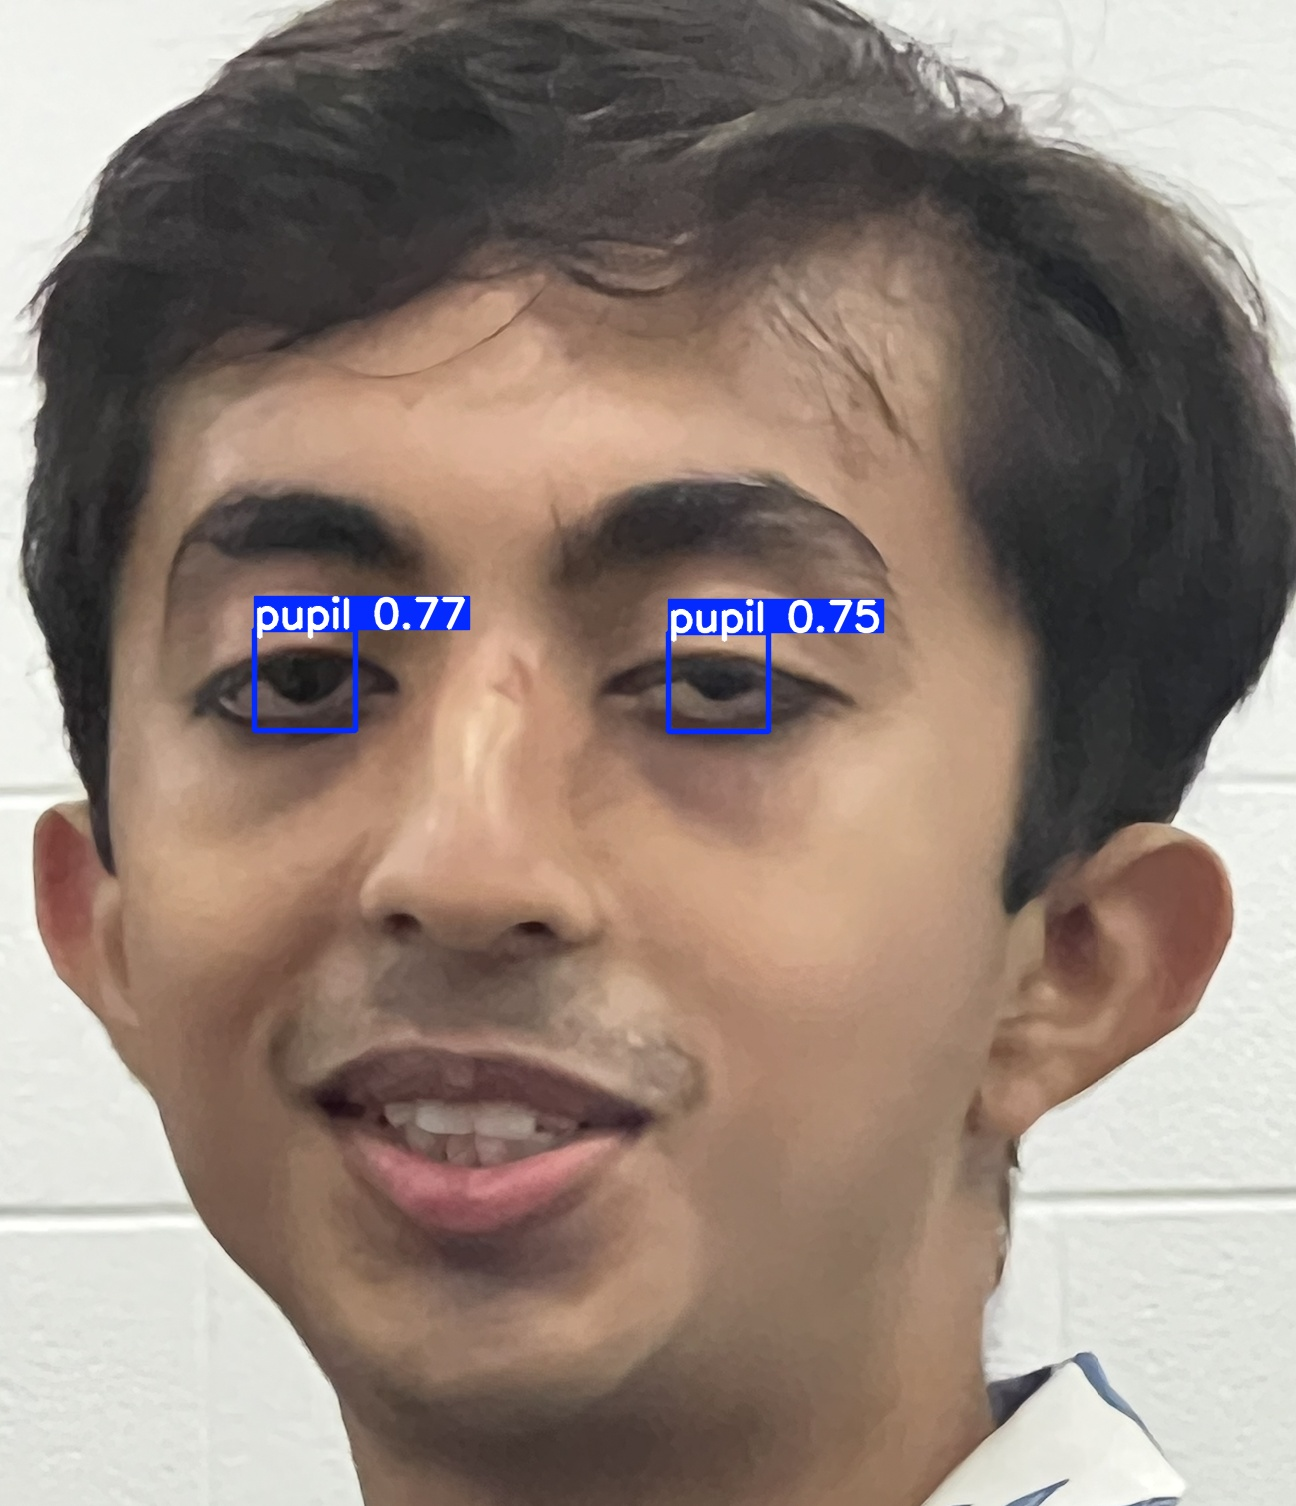

In [39]:
# # --- Step 1: Download the image by pretending to be a browser ---
# !wget --user-agent="Mozilla/5.0" -O test_face.jpg "https://images.pexels.com/photos/1043474/pexels-photo-1043474.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500"

# --- Step 2: Run prediction on the test image ---
# This will now work because the download succeeds.
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source="runs/detect/predict/test_face.jpg"

# --- Step 3: Display the result dynamically ---
from IPython.display import Image
import glob
import os

# Find the most recent prediction folder
list_of_files = glob.glob('runs/detect/predict*')
latest_dir = max(list_of_files, key=os.path.getctime)
print(f"Displaying results from: {latest_dir}")

# Display the image
Image(filename=f'{latest_dir}/test_face.jpg')

In [40]:
# List the first 5 files in the training directory to confirm they exist
!ls -l /content/datasets/pupils/images/train | head -n 5

total 23184
-rw-r--r-- 1 root root 12489 Sep 17 22:52 BioID_0000.jpg
-rw-r--r-- 1 root root 12253 Sep 17 22:52 BioID_0001.jpg
-rw-r--r-- 1 root root 12209 Sep 17 22:52 BioID_0002.jpg
-rw-r--r-- 1 root root 12255 Sep 17 22:52 BioID_0003.jpg
